# Подготовка

Используем 2 лучших классификатора из прошлых экспериментов экспериментов

- RandomForestClassifier(n_estimators=150), precicion: 0.8608339728830903, recall: 0.801954242135367

- RF + XGBoost stacking, precicion=0.82435319, recall=0.82769304,

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from utils import get_best_threshold

In [2]:
wallets_features = pd.read_csv("../dataset/custom/wallets_features_aggregated.csv")


In [3]:
%load_ext autoreload

In [ ]:
%autoreload 2

from utils import (
    prepare_wallets_features_data,
    get_training_data,
    print_confusion_matrix
)

In [13]:
prep_data = prepare_wallets_features_data(wallets_features, type="raw")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)


In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [15]:
y_train.value_counts()

class
0    565989
1     10070
Name: count, dtype: int64

In [16]:
y_resampled.value_counts()

class
0    565989
1    565989
Name: count, dtype: int64

# Эксперимент 1 - RandomOverSampler


        Best threshold: 0.5262631578947369
        Best F1: 0.8155411202353228, precicion: 0.8395155185465556, recall: 0.7928979980934223
        


{'thr': 0.5262631578947369,
 'precicion': 0.8395155185465556,
 'recall': 0.7928979980934223,
 'f1': 0.8155411202353228}

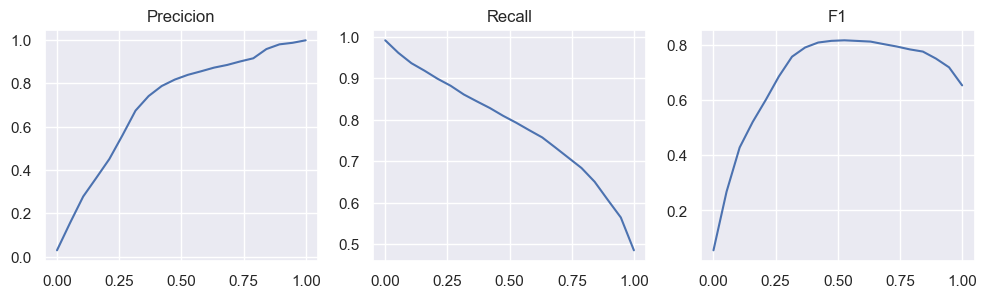

In [ ]:
from imblearn.over_sampling import RandomOverSampler
prep_data = prepare_wallets_features_data(wallets_features, type="full")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)
ros = RandomOverSampler(random_state=42,)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(prep_data.columns) - set(["addrId", "class"]))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('rf', RandomForestClassifier(n_estimators=150))
])

model = pipeline.fit(X_resampled, y_resampled)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

get_best_threshold(y_pred, y_test)

In [18]:
results, thrs, prec_hist, rec_hist = get_best_threshold(y_pred, y_test, plot=False, return_hists=True, thrs_cnt=50)
np.vstack((thrs, prec_hist, rec_hist)).T

array([[0.001     , 0.02878126, 0.99189704],
       [0.02136735, 0.07039352, 0.97712107],
       [0.04173469, 0.12066966, 0.96711153],
       [0.06210204, 0.17456868, 0.95734032],
       [0.08246939, 0.20856484, 0.94828408],
       [0.10283673, 0.27066016, 0.93898951],
       [0.12320408, 0.30265912, 0.93040991],
       [0.14357143, 0.33706986, 0.92445186],
       [0.16393878, 0.37362744, 0.9163489 ],
       [0.18430612, 0.41183458, 0.90896092],
       [0.20467347, 0.44085771, 0.90157293],
       [0.22504082, 0.47895408, 0.8948999 ],
       [0.24540816, 0.52073154, 0.88894185],
       [0.26577551, 0.5650978 , 0.88131554],
       [0.28614286, 0.61519072, 0.87249762],
       [0.3065102 , 0.65789951, 0.86439466],
       [0.32687755, 0.68475157, 0.857245  ],
       [0.3472449 , 0.71200638, 0.8508103 ],
       [0.36761224, 0.74064786, 0.84461392],
       [0.38797959, 0.75553644, 0.83746425],
       [0.40834694, 0.77557829, 0.83102955],
       [0.42871429, 0.79001368, 0.82578646],
       [0.


        Best threshold: 0.3686842105263158
        Best F1: 0.8044317191584713, precicion: 0.8420641125879593, recall: 0.7700190657769304
        


{'thr': 0.3686842105263158,
 'precicion': 0.8420641125879593,
 'recall': 0.7700190657769304,
 'f1': 0.8044317191584713}

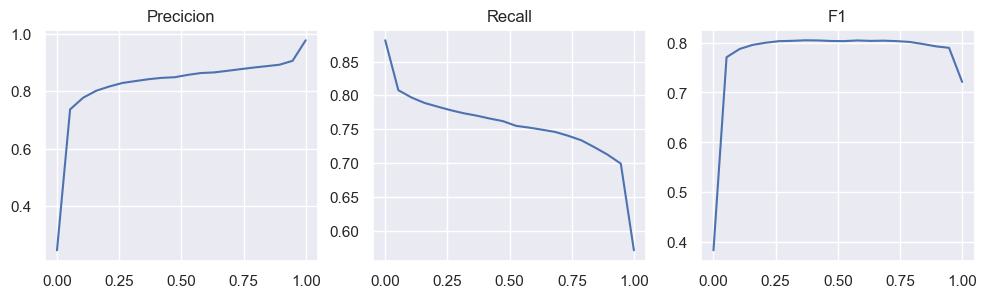

In [23]:
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

prep_data = prepare_wallets_features_data(wallets_features, type="full_with_extra_flags")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)
ros = RandomOverSampler(random_state=42,)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(prep_data.columns) - set(["addrId", "class"]))),
    ]
)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100)),
        ('xgb', xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, subsample=0.8))
    ],
    final_estimator=LogisticRegression()
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('clf', stacking_clf)
])

model = pipeline.fit(X_resampled, y_resampled)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

get_best_threshold(y_pred, y_test)

In [24]:
results, thrs, prec_hist, rec_hist = get_best_threshold(y_pred, y_test, plot=False, return_hists=True, thrs_cnt=150)
np.vstack((thrs, prec_hist, rec_hist)).T

array([[0.001     , 0.24568164, 0.88131554],
       [0.00769799, 0.57372524, 0.84199237],
       [0.01439597, 0.64246222, 0.83079123],
       [0.02109396, 0.67230979, 0.82340324],
       [0.02779195, 0.6960665 , 0.81816015],
       [0.03448993, 0.71366097, 0.81673022],
       [0.04118792, 0.72318779, 0.81315539],
       [0.04788591, 0.73149742, 0.81029552],
       [0.05458389, 0.73758711, 0.80719733],
       [0.06128188, 0.7434428 , 0.80386082],
       [0.06797987, 0.74894374, 0.80266921],
       [0.07467785, 0.75324966, 0.80100095],
       [0.08137584, 0.75715896, 0.80028599],
       [0.08807383, 0.76430362, 0.79909438],
       [0.09477181, 0.76852489, 0.79837941],
       [0.1014698 , 0.77441   , 0.79766444],
       [0.10816779, 0.77943577, 0.79671115],
       [0.11486577, 0.78264947, 0.79551954],
       [0.12156376, 0.78729934, 0.79480458],
       [0.12826174, 0.79096314, 0.79265968],
       [0.13495973, 0.79293893, 0.79218303],
       [0.14165772, 0.79459589, 0.79194471],
       [0.

# Эксперимент 2 - ADASYN


        Best threshold: 0.7888947368421053
        Best F1: 0.7871712951585156, precicion: 0.8125317097919837, recall: 0.7633460438512869
        


{'thr': 0.7888947368421053,
 'precicion': 0.8125317097919837,
 'recall': 0.7633460438512869,
 'f1': 0.7871712951585156}

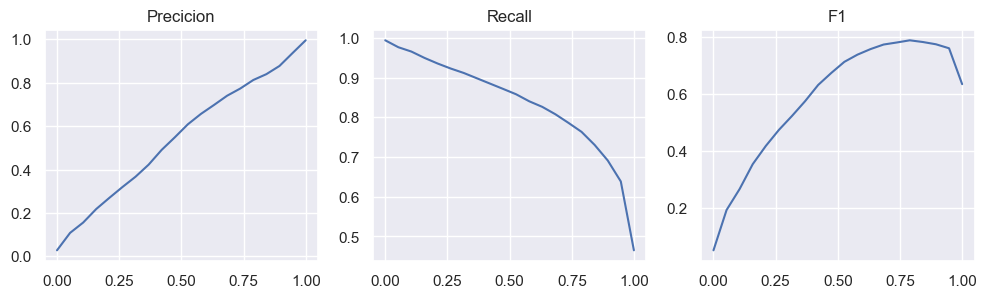

In [25]:
from imblearn.over_sampling import ADASYN
prep_data = prepare_wallets_features_data(wallets_features, type="full")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)
adasyn_sampler = ADASYN(random_state=42,)
X_resampled, y_resampled = adasyn_sampler.fit_resample(X_train, y_train)


column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(prep_data.columns) - set(["addrId", "class"]))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('rf', RandomForestClassifier(n_estimators=150))
])

model = pipeline.fit(X_resampled, y_resampled)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

get_best_threshold(y_pred, y_test)

In [31]:
print_confusion_matrix(y_pred, 0.5, y_test)


	real 1	real 0
pred 1	3629	2615	
pred 0	567	240072	


Ощутимого результата нет

# Cost matrix


        Best threshold: 0.8939473684210526
        Best F1: 0.7475285171102662, precicion: 0.7983216025988089, recall: 0.7028122020972355
        


{'thr': 0.8939473684210526,
 'precicion': 0.7983216025988089,
 'recall': 0.7028122020972355,
 'f1': 0.7475285171102662}

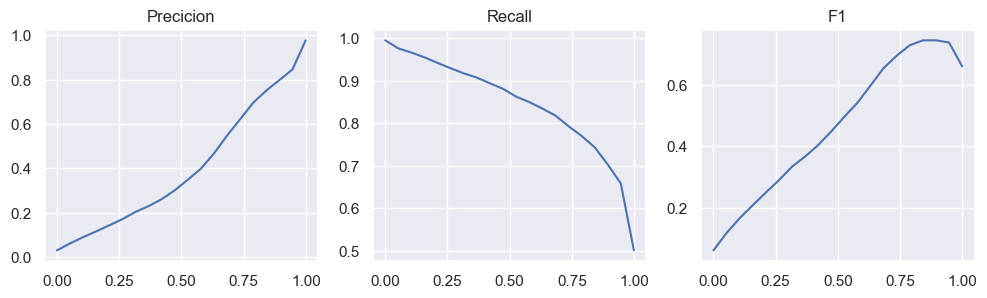

In [33]:
prep_data = prepare_wallets_features_data(wallets_features, type="full")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)


column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(prep_data.columns) - set(["addrId", "class"]))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('rf', RandomForestClassifier(n_estimators=150, class_weight={0: 1, 1: 30}))
])

model = pipeline.fit(X_resampled, y_resampled)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

get_best_threshold(y_pred, y_test)

In [34]:
y_train.value_counts()

class
0    565989
1     10070
Name: count, dtype: int64


        Best threshold: 0.8939473684210526
        Best F1: 0.7525982256020279, precicion: 0.8037357877639415, recall: 0.7075786463298379
        


{'thr': 0.8939473684210526,
 'precicion': 0.8037357877639415,
 'recall': 0.7075786463298379,
 'f1': 0.7525982256020279}

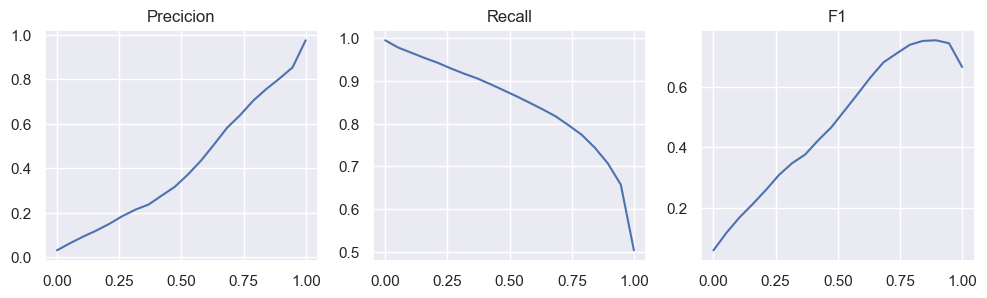

In [35]:
prep_data = prepare_wallets_features_data(wallets_features, type="full")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)


column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(prep_data.columns) - set(["addrId", "class"]))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('rf', RandomForestClassifier(n_estimators=150, class_weight={0: 1, 1: 20}))
])

model = pipeline.fit(X_resampled, y_resampled)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

get_best_threshold(y_pred, y_test)


        Best threshold: 0.8939473684210526
        Best F1: 0.7525982256020279, precicion: 0.8037357877639415, recall: 0.7075786463298379
        


{'thr': 0.8939473684210526,
 'precicion': 0.8037357877639415,
 'recall': 0.7075786463298379,
 'f1': 0.7525982256020279}

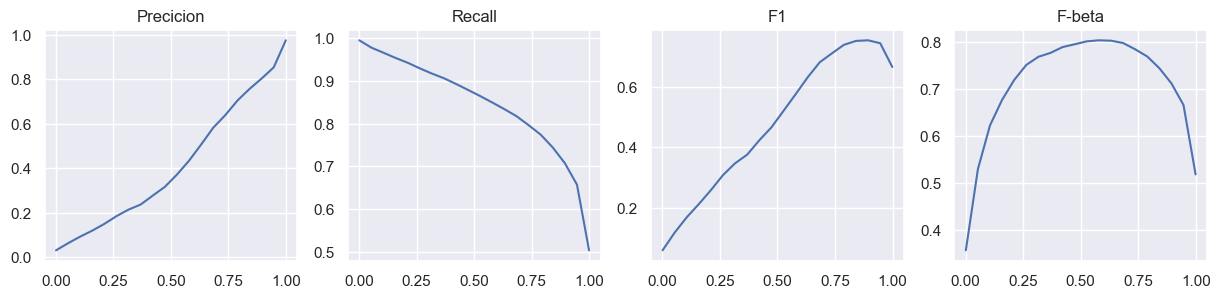

In [39]:
get_best_threshold(y_pred, y_test)


        Best threshold: 0.3686842105263158
        Best F1: 0.8200316802729378, precicion: 0.8389429070057343, recall: 0.801954242135367
        


{'thr': 0.3686842105263158,
 'precicion': 0.8389429070057343,
 'recall': 0.801954242135367,
 'f1': 0.8200316802729378}

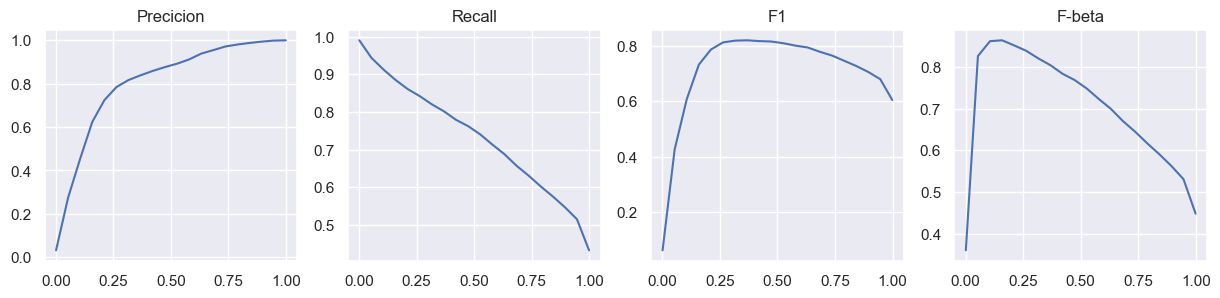

In [96]:
prep_data = prepare_wallets_features_data(wallets_features, type="full_with_extra_flags")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)


column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(prep_data.columns) - set(["addrId", "class"]))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('rf', RandomForestClassifier(n_estimators=150, class_weight={0: 1, 1: 15}))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

get_best_threshold(y_pred, y_test)

In [ ]:
prep_data = prepare_wallets_features_data(wallets_features, type="full_with_extra_flags")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)


column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(prep_data.columns) - set(["addrId", "class"]))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('rf', RandomForestClassifier(n_estimators=150, class_weight={0: 1, 1: 5}))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

get_best_threshold(y_pred, y_test)


        Best threshold: 0.5787894736842105
        Best F1: 0.7963824289405685, precicion: 0.8696388261851016, recall: 0.734509056244042
        


{'thr': 0.5787894736842105,
 'precicion': 0.8696388261851016,
 'recall': 0.734509056244042,
 'f1': 0.7963824289405685}

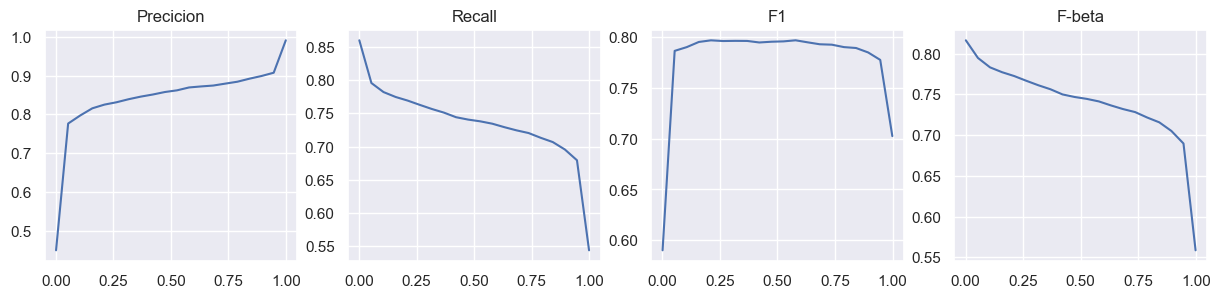

In [92]:
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

prep_data = prepare_wallets_features_data(wallets_features, type="full_with_extra_flags")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)
ros = RandomOverSampler(random_state=42,)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(prep_data.columns) - set(["addrId", "class"]))),
    ]
)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, class_weight={0: 1, 1: 3})),
        ('xgb', xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, subsample=0.8, scale_pos_weight=3))
    ],
    final_estimator=LogisticRegression()
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('clf', stacking_clf)
])

model = pipeline.fit(X_resampled, y_resampled)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

get_best_threshold(y_pred, y_test)


        Best threshold: 0.3161578947368421
        Best F1: 0.7945696721311477, precicion: 0.8588039867109635, recall: 0.7392755004766445
        


{'thr': 0.3161578947368421,
 'precicion': 0.8588039867109635,
 'recall': 0.7392755004766445,
 'f1': 0.7945696721311477}

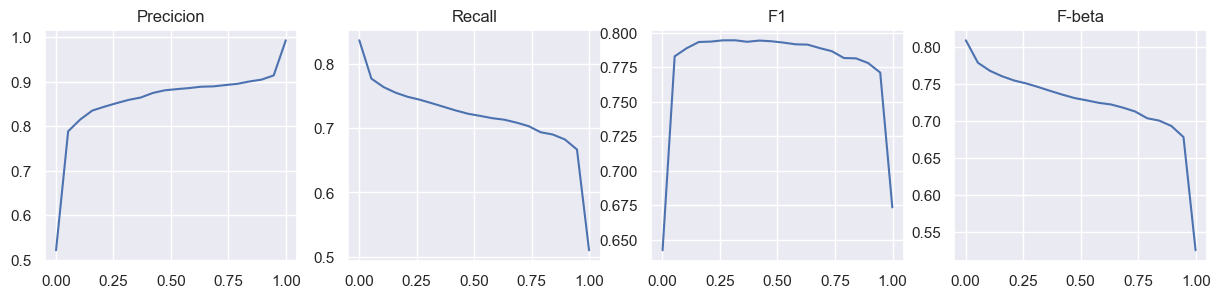

In [93]:
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

prep_data = prepare_wallets_features_data(wallets_features, type="full")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)
ros = RandomOverSampler(random_state=42,)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(prep_data.columns) - set(["addrId", "class"]))),
    ]
)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, class_weight={0: 1, 1: 3})),
        ('xgb', xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, subsample=0.8, scale_pos_weight=3))
    ],
    final_estimator=LogisticRegression()
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('clf', stacking_clf)
])

model = pipeline.fit(X_resampled, y_resampled)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

get_best_threshold(y_pred, y_test)

In [ ]:
print_confusion_matrix(y_pred, )

## Выводы из class weight

Появилась возможность повысить recall > 90%, но с огромным уменьшением precicion

Лучший результат с высоким precicion был в стекинге RF + XGBoost c 70% precicion и 90% recall